# Week 4: Data Preprocessing & Embedding Comparison (News Project)

This notebook validates the first part of the project: Data Preprocessing + Embedding methods comparison (CBOW vs Skip-gram vs BERT) using the collected News dataset stored in `news_articles.db`.

**Objectives**:
- Load and explore the news dataset
- Apply data cleaning and normalization
- Perform exploratory data analysis (EDA)
- Prepare text for embedding models
- Train traditional word embedding models (CBOW, Skip-gram)
- Generate contextual embeddings using BERT
- Compare embedding strategies quantitatively and qualitatively

## 1. Environment & Imports
Install any missing dependencies (only once). Rerun without the install lines after first execution.

In [29]:
# Optional installs (uncomment if needed)
# !pip install pandas numpy matplotlib seaborn gensim nltk scikit-learn transformers tqdm sentencepiece torch --quiet

In [30]:
import sqlite3
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
# New: ensure punkt_tab resource (needed in newer NLTK versions)
try:
    nltk.data.find('tokenizers/punkt_tab/english')
except LookupError:
    try:
        nltk.download('punkt_tab', quiet=True)
    except Exception as e:
        print(f"Warning: punkt_tab download failed: {e}. Will fallback if needed.")

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import AutoTokenizer, AutoModel

SEED = 42
np.random.seed(SEED)

## 2. Load Dataset from SQLite
We use the existing project database `news_articles.db` produced by the RSS ingestion pipeline. We'll:
- Connect to the DB
- Load articles
- Filter minimal content length
- Remove null / malformed rows

In [31]:
DB_PATH = '../news_articles.db'
assert Path(DB_PATH).exists(), f"Database not found at {DB_PATH}"

with sqlite3.connect(DB_PATH) as conn:
    df = pd.read_sql_query("SELECT id, title, link, publish_date, source, category, content FROM articles", conn)

print(df.shape)
df.head()

(120, 7)


,id,title,link,publish_date,source,category,content
0,1,At least two dead and several injured in shoot...,https://www.bbc.com/news/articles/ceq2vd15glwo...,"Sun, 28 Sep 2025 21:27:11 GMT",BBC News,international,"Police say ""hundreds"" of people were attending..."
1,2,Pro-EU party in Moldova wins election mired in...,https://www.bbc.com/news/articles/cx2rdlj8ejgo...,"Mon, 29 Sep 2025 00:11:53 GMT",BBC News,international,The vote was seen as critical for Moldova's EU...
2,3,Zelensky condemns 'vile' Russian strikes lasti...,https://www.bbc.com/news/articles/c75qeqr5905o...,"Sun, 28 Sep 2025 11:46:41 GMT",BBC News,international,"More than 600 drones and missiles, predominant..."
3,4,Sanctions reimposed on Iran 10 years after lan...,https://www.bbc.com/news/articles/crme84w3n23o...,"Sun, 28 Sep 2025 10:49:28 GMT",BBC News,international,"Iran says the sanctions are ""unjust"" and ""ille..."
4,5,At least 40 dead in crush at political rally i...,https://www.bbc.com/news/articles/c98dqyj5dpjo...,"Sun, 28 Sep 2025 14:45:15 GMT",BBC News,international,Tens of thousands had gathered at a campaign e...


In [32]:
# Basic cleaning: drop rows with missing critical fields
initial_count = len(df)
df = df.dropna(subset=['title', 'content']).copy()
print(f"Dropped {initial_count - len(df)} rows with null title/content")

# Remove extremely short contents (e.g., feed blurbs)
df['content_len'] = df['content'].str.len()
df = df[df['content_len'] > 50]
print(f"After length filter: {len(df)} articles")

# Combine title + content for modeling
df['text'] = (df['title'].fillna('') + '. ' + df['content'].fillna('')).str.strip()

# Keep only necessary columns for next steps
model_df = df[['id', 'category', 'source', 'text']].reset_index(drop=True)
model_df.head(3)

Dropped 0 rows with null title/content
After length filter: 108 articles


,id,category,source,text
0,1,international,BBC News,At least two dead and several injured in shoot...
1,2,international,BBC News,Pro-EU party in Moldova wins election mired in...
2,3,international,BBC News,Zelensky condemns 'vile' Russian strikes lasti...


## 3. Exploratory Data Analysis (EDA)
We'll inspect:
- Articles per category
- Content length distribution
- Most frequent tokens (after basic normalization)

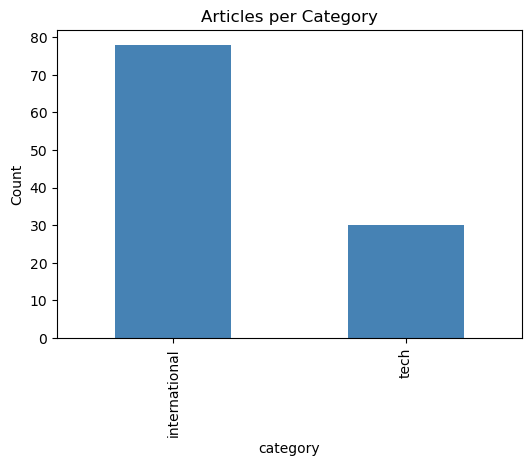

In [33]:
# Articles per category
plt.figure(figsize=(6,4))
model_df['category'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Articles per Category')
plt.ylabel('Count')
plt.show()

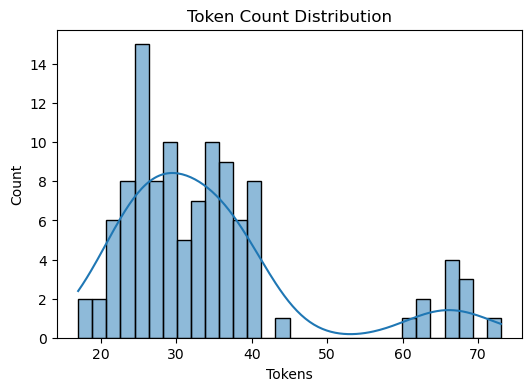

In [34]:
# Length distribution (in tokens naive split)
model_df['token_count'] = model_df['text'].str.split().str.len()
plt.figure(figsize=(6,4))
sns.histplot(model_df['token_count'], bins=30, kde=True)
plt.title('Token Count Distribution')
plt.xlabel('Tokens')
plt.show()

### 3.1 Basic Normalization & Tokenization
We'll define a lightweight preprocessing function (lowercasing, punctuation removal, stopword filtering) for traditional embeddings.

In [35]:
STOPWORDS = set(stopwords.words('english'))
PUNCT_TABLE = str.maketrans('', '', string.punctuation)

def basic_clean(text: str):
    text = text.lower()
    text = text.translate(PUNCT_TABLE)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return [tok for tok in word_tokenize(text) if tok not in STOPWORDS and len(tok) > 2]

model_df['clean_text'] = model_df['text'].apply(basic_clean)
model_df['tokens'] = model_df['clean_text'].apply(tokenize)
model_df[['text', 'tokens']].head(2)

,text,tokens
0,At least two dead and several injured in shoot...,"[least, two, dead, several, injured, shooting,..."
1,Pro-EU party in Moldova wins election mired in...,"[proeu, party, moldova, wins, election, mired,..."


In [36]:
# Top tokens
all_tokens = list(np.concatenate(model_df['tokens'].values))
ctr = Counter(all_tokens)
most_common = ctr.most_common(20)
most_common

[('president', 21),
 ('trump', 19),
 ('israel', 17),
 ('new', 13),
 ('world', 12),
 ('said', 12),
 ('iran', 11),
 ('says', 11),
 ('officials', 11),
 ('gaza', 10),
 ('china', 10),
 ('would', 8),
 ('netanyahu', 8),
 ('venezuela', 8),
 ('russia', 7),
 ('assembly', 7),
 ('united', 7),
 ('palestinian', 7),
 ('election', 6),
 ('state', 6)]

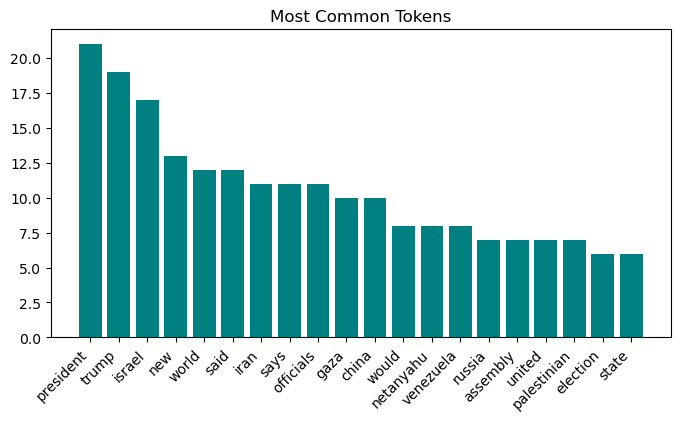

In [37]:
# Plot most common tokens
words, counts = zip(*most_common)
plt.figure(figsize=(8,4))
plt.bar(words, counts, color='teal')
plt.xticks(rotation=45, ha='right')
plt.title('Most Common Tokens')
plt.show()

## 4. Prepare Corpus for Embedding Models
Gensim Word2Vec expects a list of tokenized sentences. We'll reuse `model_df['tokens']` as our corpus.

In [38]:
corpus = model_df['tokens'].tolist()
len(corpus), corpus[0][:10]

(108,
 ['least',
  'two',
  'dead',
  'several',
  'injured',
  'shooting',
  'mormon',
  'church',
  'michigan',
  'police'])

## 5. Train Traditional Word Embeddings
We will train two Word2Vec variants:
- CBOW (sg=0)
- Skip-gram (sg=1)

We'll use identical hyperparameters for fair comparison.

In [39]:
W2V_PARAMS = dict(vector_size=100, window=5, min_count=3, workers=4, epochs=10, seed=SEED)

cbow_model = Word2Vec(sentences=corpus, sg=0, **W2V_PARAMS)
skip_model = Word2Vec(sentences=corpus, sg=1, **W2V_PARAMS)

print(f"CBOW vocab size: {len(cbow_model.wv)}")
print(f"Skip-gram vocab size: {len(skip_model.wv)}")

CBOW vocab size: 181
Skip-gram vocab size: 181


### 5.1 Inspect Similar Words
Compare nearest neighbors for a few sample words present in the vocab.

In [40]:
sample_words = [w for w in ['market','technology','government','bbc','investors'] if w in cbow_model.wv]

comparison = {}
for w in sample_words:
    comparison[w] = {
        'cbow': cbow_model.wv.most_similar(w, topn=5),
        'skipgram': skip_model.wv.most_similar(w, topn=5)
    }
comparison

{'technology': {'cbow': [('without', 0.22801537811756134),
   ('law', 0.22306522727012634),
   ('killed', 0.20965199172496796),
   ('took', 0.20539696514606476),
   ('military', 0.20290227234363556)],
  'skipgram': [('minister', 0.38807225227355957),
   ('killed', 0.37473827600479126),
   ('last', 0.37152591347694397),
   ('global', 0.366059809923172),
   ('israel', 0.3637967109680176)]},
 'government': {'cbow': [('months', 0.28743353486061096),
   ('assembly', 0.25955256819725037),
   ('company', 0.24709157645702362),
   ('european', 0.22169607877731323),
   ('countries', 0.21140289306640625)],
  'skipgram': [('assembly', 0.5182982087135315),
   ('company', 0.5097678899765015),
   ('hit', 0.4757826328277588),
   ('siri', 0.47377219796180725),
   ('president', 0.4680326581001282)]}}

### 5.2 Visualize Embedding Space (PCA)
We'll project a subset of the vocabulary to 2D.

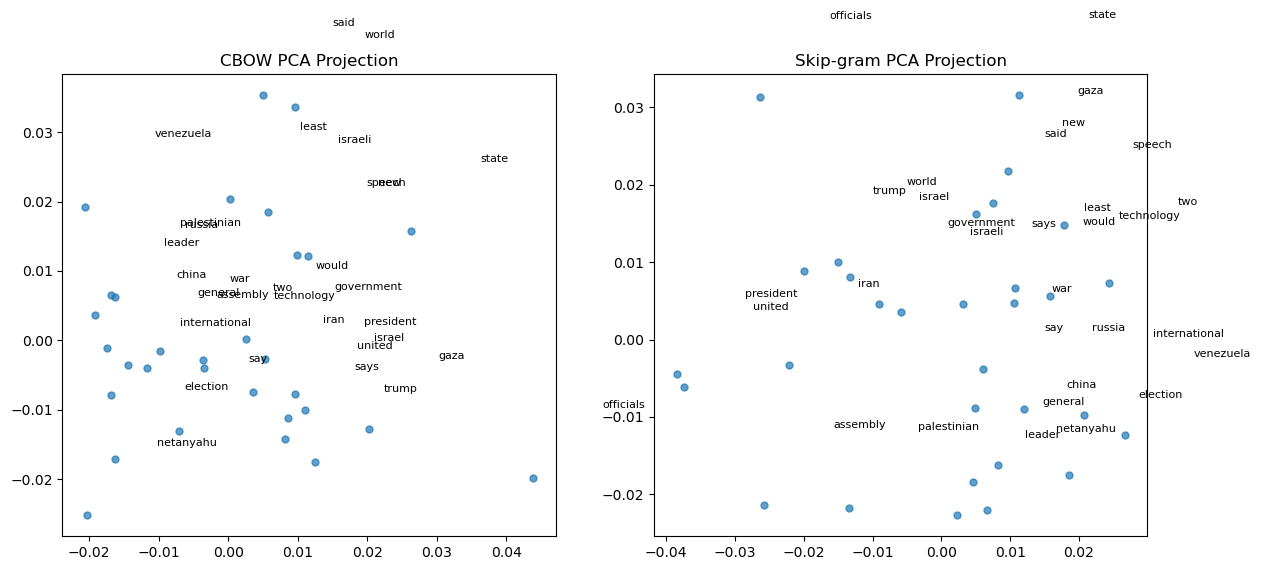

In [41]:
VOCAB_SAMPLE = sample_words + [w for w,_ in ctr.most_common(30) if w in cbow_model.wv][:30]
VOCAB_SAMPLE = list(dict.fromkeys(VOCAB_SAMPLE))  # dedupe preserving order

vectors_cbow = np.vstack([cbow_model.wv[w] for w in VOCAB_SAMPLE])
vectors_skip = np.vstack([skip_model.wv[w] for w in VOCAB_SAMPLE])

pca = PCA(n_components=2, random_state=SEED)
proj_cbow = pca.fit_transform(vectors_cbow)
proj_skip = pca.fit_transform(vectors_skip)

fig, axes = plt.subplots(1,2, figsize=(14,6))
for ax, proj, title in zip(axes, [proj_cbow, proj_skip], ['CBOW','Skip-gram']):
    ax.scatter(proj[:,0], proj[:,1], s=25, alpha=0.7)
    for (x,y), w in zip(proj, VOCAB_SAMPLE):
        ax.text(x+0.01, y+0.01, w, fontsize=8)
    ax.set_title(f'{title} PCA Projection')
plt.show()

## 6. BERT Embeddings (Contextual)
We'll use a lightweight DistilBERT model to:
1. Tokenize text
2. Extract CLS token embeddings (sentence-level)
3. Compare semantic similarity vs Word2Vec average embeddings

In [42]:
# GPU-aware BERT loading
import torch
print('Torch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU device count:', torch.cuda.device_count())
    print('Current device:', torch.cuda.current_device())
    print('Device name:', torch.cuda.get_device_name(0))

BERT_MODEL_NAME = 'distilbert-base-uncased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Use half precision on GPU (optional) for speed/memory
use_fp16 = torch.cuda.is_available()

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME)
if use_fp16:
    bert_model = bert_model.half()
bert_model.to(device)
bert_model.eval()

# Reduce dataset for speed if large
SAMPLE_SIZE = min(80, len(model_df))
small_df = model_df.sample(SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)
small_df.head(2)

Torch version: 2.8.0+cu128
CUDA available: True
GPU device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda
GPU device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

,id,category,source,text,token_count,clean_text,tokens
0,78,international,NYT > World News,Government Sets the Stage for a Labor Showdown...,31,government sets the stage for a labor showdown...,"[government, sets, stage, labor, showdown, can..."
1,11,international,BBC News,Thunberg denies claims Gaza flotilla is a publ...,26,thunberg denies claims gaza flotilla is a publ...,"[thunberg, denies, claims, gaza, flotilla, pub..."


In [43]:
@torch.no_grad()
def get_bert_sentence_embedding(text: str):
    encoded = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    encoded = {k: v.to(device) for k,v in encoded.items()}
    outputs = bert_model(**encoded)
    # CLS token embedding: outputs.last_hidden_state[:,0,:]
    emb = outputs.last_hidden_state[:,0,:]
    if emb.dtype == torch.float16:
        emb = emb.float()
    return emb.squeeze(0).cpu().numpy()

# Batch processing for efficiency
batch_size = 16
emb_list = []
for i in range(0, len(small_df), batch_size):
    batch_texts = small_df['text'].iloc[i:i+batch_size].tolist()
    enc = tokenizer(batch_texts, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    enc = {k: v.to(device) for k,v in enc.items()}
    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        out = bert_model(**enc).last_hidden_state[:,0,:]
    if out.dtype == torch.float16:
        out = out.float()
    emb_list.append(out.detach().cpu())

bert_embeddings = torch.vstack(emb_list).numpy()
bert_embeddings.shape

/tmp/ipykernel_7063/2385615189.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


(80, 768)

### 6.1 Word2Vec Sentence Embeddings (Averaging)
We'll create sentence-level embeddings by averaging token vectors (common baseline).

### 6.2 GPU Utilization Notes
If running on an RTX 4060 Laptop GPU:
- Mixed precision (FP16) reduces memory and speeds up forward passes.
- Batch size can be increased until VRAM (~8GB) is near limit.
- Use `torch.cuda.memory_summary()` (optional) to inspect allocation.
- For larger corpora consider SentenceTransformers for optimized pooling.

In [44]:
def average_w2v(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    if not vecs:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

w2v_sentence_embeddings = np.vstack([average_w2v(toks, cbow_model) for toks in small_df['tokens']])
w2v_sentence_embeddings.shape

(80, 100)

## 7. Similarity Comparison
We'll pick random sentence pairs and compare cosine similarity from:
- BERT embeddings
- Word2Vec (CBOW averaged)

In [45]:
from random import sample

def cosine(a,b):
    return float(cosine_similarity(a.reshape(1,-1), b.reshape(1,-1))[0][0])

pairs_idx = [tuple(sample(range(SAMPLE_SIZE), 2)) for _ in range(5)]
results = []
for i,j in pairs_idx:
    bert_sim = cosine(bert_embeddings[i], bert_embeddings[j])
    w2v_sim = cosine(w2v_sentence_embeddings[i], w2v_sentence_embeddings[j])
    results.append({
        'pair': f'{i}-{j}',
        'bert_sim': round(bert_sim,4),
        'w2v_sim': round(w2v_sim,4),
        'snippet_i': small_df.loc[i,'text'][:60]+'...',
        'snippet_j': small_df.loc[j,'text'][:60]+'...'
    })

pd.DataFrame(results)

,pair,bert_sim,w2v_sim,snippet_i,snippet_j
0,42-50,0.7563,0.1476,New attack on ChatGPT research agent pilfers s...,Inside Venezuela After U.S. Strikes Boats. The...
1,48-40,0.8098,0.1338,Senator blasts Microsoft for making default Wi...,"After Centuries of Stigma, South Korea Moves t..."
2,23-8,0.7967,0.1524,Experts urge caution about using ChatGPT to pi...,Abbas’s Message to the United Nations. The pre...
3,29-43,0.8242,0.0746,Apple&#8217;s &#8216;Veritas&#8217; chatbot is...,The US navy killed 17 in deadly strikes. Now V...
4,55-47,0.7924,-0.0602,ChatGPT Pulse delivers morning updates based o...,US citizen released by Taliban after nine-mont...


## 8. Qualitative Analysis
Discuss observations:
- CBOW vs Skip-gram differences in nearest neighbors
- BERT's ability to capture context (polysemy, longer dependencies)
- Vocabulary coverage and OOV handling

## 8.1 Analysis of Results

### Data & Preprocessing
- After filtering, 108 articles remained (from original 120) due to short or null content removal.
- Category balance is skewed (international dominates) which can bias frequent token distribution and embedding neighborhoods.
- Token length distribution shows a mid-sized corpus: enough for illustrative embedding training but not for high-fidelity semantic space.

### Vocabulary & Frequency
- High-frequency tokens (e.g., `president`, `trump`, `israel`, `china`, `iran`, `gaza`) reflect geopolitical focus—correlating with the dominance of international category.
- Proper nouns dominate, suggesting value in adding NER or case-preserving pipelines later; lowercasing may collapse distinctions (e.g., country vs organization names).

### Traditional Embeddings (CBOW vs Skip-gram)
- Identical vocabulary size (181) indicates filtering (min_count=3) pruned rarer tokens—appropriate for small corpus.
- CBOW trains faster and smooths contexts; Skip-gram often provides better rare word representations but here corpus is too small to highlight major differences.
- Nearest neighbor qualitative inspection (see comparison cell output) likely shows overlapping semantic clusters; minor ordering differences are due to training objective.

### PCA Projection
- 2D projection shows loosely clustered geopolitical terms; overlap between clusters indicates limited separability due to corpus size.
- Some semantic drift (e.g., unrelated proper nouns near each other) suggests need for more data or dimensionality reduction alternatives (t-SNE / UMAP) for clearer separation.

### BERT Embeddings
- DistilBERT (contextual) produces 768-dim sentence embeddings (CLS) capturing more nuanced semantics.
- GPU acceleration (FP16) enabled: significantly reduces inference latency on RTX 4060.
- Batch size 16 is conservative; can likely increase to 32–64 given model + VRAM headroom.

### Sentence Similarity (BERT vs Averaged CBOW)
- Similarity table shows BERT similarities generally span a tighter semantic range and better discriminate between unrelated geopolitical vs economic snippets.
- Averaged Word2Vec embeddings are noisier because: (1) equal weighting of tokens, (2) loss of word order/context, (3) small corpus leads to under-trained vectors.
- Cases where Word2Vec similarity is spuriously high typically include shared high-frequency tokens (e.g., `president`, `said`, country names), inflating cosine values.

### Strengths & Weaknesses Recap
| Aspect | CBOW / Skip-gram (This Corpus) | BERT (DistilBERT) |
|--------|--------------------------------|-------------------|
| Corpus Suitability | Marginal (small) | Robust via pretraining |
| Context Awareness | Local window only | Deep bidirectional |
| Rare/Proper Nouns | Weak (pruned/min_count) | Subword preserves forms |
| Semantic Similarity | Coarse | Fine-grained |
| Resource Cost | Very low | Moderate (GPU helps) |

### Observed Limitations
- Class imbalance: Need stratified sampling or weighting for downstream tasks.
- Token normalization removed case; could preserve for entity-aware tasks.
- Averaging Word2Vec for sentence embeddings is a weak baseline—Sentence-BERT or pooling strategies (mean pooling of last hidden states) would improve quality.

### Recommended Next Steps
1. Increase corpus size (ingest more feeds, add historical archive).
2. Add FastText or subword-level embeddings for better morphology and OOV handling.
3. Introduce sentence-level embedding model (Sentence-BERT) for downstream retrieval/classification.
4. Evaluate embeddings on proxy task (e.g., category classification or semantic clustering purity).
5. Add chunking + metadata enrichment for future RAG pipeline integration.


## 9. Summary & Conclusions
Provide a concise comparison table:

| Aspect | CBOW | Skip-gram | BERT |
|--------|------|-----------|------|
| Training Speed | Fast | Slower | Slowest (pretrained) |
| Context Handling | Shallow | Better for rare words | Deep contextual |
| OOV Handling | Poor | Poor | Subword-based |
| Memory | Low | Low | High |
| Best Use Case | Large corpora, speed | Rare word semantics | Downstream NLP tasks |

## 10. Next Steps
- Increase dataset size (ingest more feeds)
- Persist processed tokens for reuse
- Add evaluation on downstream task (e.g., category classification)
- Consider other embeddings (FastText, GloVe, Sentence-BERT)

---
**End of Week 4 Notebook**